In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster as cluster

In [2]:
!pip install --upgrade xlrd

     |████████████████████████████████| 96 kB 3.8 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
def read_data():
  df = pd.read_excel('/content/drive/MyDrive/climate-change-excel-4-6-mb-.xls', index_col=0)
  return df

def fill_na(df):
  df = df.replace(r'^\..*$', np.NaN, regex=True)
  df.fillna(0, inplace = True)
  return df

def pre_process(df):
  df.drop(columns= ['SCALE', 'Decimals', 'Series code',2011], inplace = True )
  df2 = df.loc[df['Series name'].isin(['CO2 emissions per capita (metric tons)','CO2 emissions per units of GDP (kg/$1,000 of 2005 PPP $)'])] 
  df1 = df.loc[df['Series name'].isin(['CO2 emissions per capita (metric tons)','CO2 emissions per units of GDP (kg/$1,000 of 2005 PPP $)'])] 
  df1['mean'] = df1.median(axis=1)
  df1.drop(columns= [1990,	1991,	1992,	1993,	1994,	1995,	1996,	1997,1998,1999,2000,	2001,	2002,	2003, 2004,	2005,	2006,	2007,	2008,	2009,	2010	], inplace = True )
  df1 = df1.reset_index()
  return df1, df2

def mean_GDP(df):
  df['mean_gdp'] = df['mean'].iloc[233:466]
  df['mean_gdp'].iloc[0:233] = df['mean'].iloc[233:466]
  df = df.drop(df.index[233:], axis=0)
  df.drop(columns= ['Country code', 'Series name'], inplace = True )
  df1 = df.drop([df.index[175],df.index[206],df.index[219]], axis=0)
  return df1

def norm(array):
  """ Returns array normalised to [0,1]. Array can be a numpy array
  or a column of a dataframe"""
  min_val = np.min(array)
  max_val = np.max(array)
  scaled = (array-min_val) / (max_val-min_val)
  return scaled

def norm_df(df):
  """
  Returns all columns of the dataframe normalised to [0,1] with the
  exception the first (containing the names)
  Calls function norm to do the normalisation of one column, but
  doing all in one function is also fine.
  """
  # iterate over all columns
  for col in df.columns[1:]: # excluding the first column
    df[col] = norm(df[col])
  return df

def makeplot(df, col1, col2):
  """
  Produces a square plot of two columns of dataframe df using small circle
  symbols.
  """
  plt.figure(figsize=(5.0,5.0))
  plt.plot(df1[col1], df1[col2], "o", markersize=3)
  plt.xlabel(col1)
  plt.ylabel(col2)
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/co

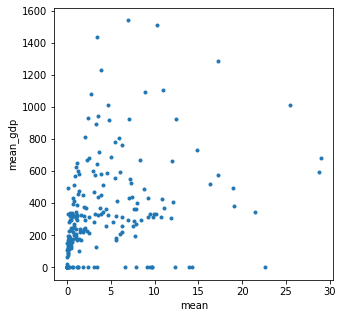

In [23]:
df = read_data()
df = fill_na(df)
df1, df2 = pre_process(df)
df1 = mean_GDP(df1)
# exploratory plots
makeplot(df1, "mean", "mean_gdp")

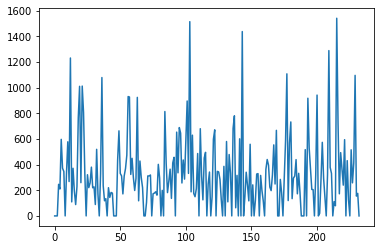

In [24]:
plt.plot(df1.mean_gdp)

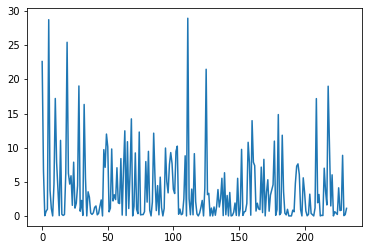

In [25]:
plt.plot(df1['mean'])

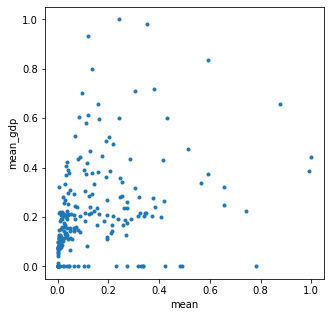

In [26]:
df_norm = norm_df(df1)
makeplot(df_norm, "mean", "mean_gdp")

# Clustering

In [27]:
kmeans = cluster.KMeans(n_clusters=3)

# extract columns for fitting
df_fit = df1[["mean", "mean_gdp"]].copy()
kmeans.fit(df_fit)

# extract labels and cluster centres
labels = kmeans.labels_
cen = kmeans.cluster_centers_

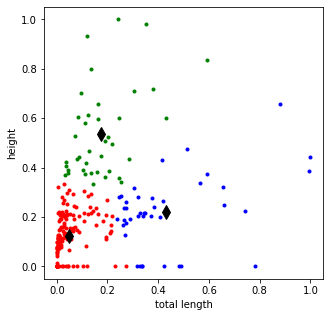

In [28]:
# plot using the labels to select colour
plt.figure(figsize=(5.0,5.0))
col = ["blue", "red", "green", "magenta"]
for l in range(4): 
  plt.plot(df_fit["mean"][labels==l], df_fit["mean_gdp"][labels==l],"o", markersize=3, color=col[l])

# show cluster centres
for ic in range(3):
  xc, yc = cen[ic,:]
  plt.plot(xc, yc, "dk", markersize=10)
plt.xlabel("total length")
plt.ylabel("height")
plt.show()

In [29]:
df1['label'] = kmeans.labels_

In [30]:
df1

,Country name,mean,mean_gdp,label
0,Aruba,0.780996,0.000000,0
1,Andorra,0.228642,0.000000,1
2,Afghanistan,0.001039,0.000000,1
3,Angola,0.023351,0.159708,1
4,Albania,0.034040,0.136204,1
...,...,...,...,...
228,"Yemen, Rep.",0.028899,0.268733,1
229,South Africa,0.306396,0.711039,2
230,"Congo, Dem. Rep.",0.001556,0.100234,1
231,Zambia,0.006712,0.114005,1


# Prediction

In [14]:
!pip install lmfit

     |████████████████████████████████| 292 kB 5.1 MB/s 
     |████████████████████████████████| 40 kB 6.5 MB/s 
     |████████████████████████████████| 98 kB 10.2 MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.3-py3-none-any.whl size=84402 sha256=55ae358e406a6f522cff1ec74e02eb64b99f4d80014ee5a380000ee6a34e53c9
  Stored in directory: /root/.cache/pip/wheels/b9/7a/d1/236aa0f8196b264fda481a112f7cfb1bfde7bfb20235f8e331
  Created wheel for asteval: filename=asteval-0.9.26-py3-none-any.whl size=17648 sha256=fbbbf5270c41ed8ef208aad58ca0e24a7f0e72a4343c4411bbdea945d550e4bf
  Stored in directory: /root/.cache/pip/wheels/4c/e9/f0/bc343d5b77d2fded45177f424a6b0b9224b92ff6e7c150bad4
Successfully built lmfit asteval


In [15]:
import matplotlib.pyplot as plt
from lmfit import Model
from numpy import exp, loadtxt, pi, sqrt
import scipy.stats as st
import seaborn as sns

In [16]:
# interval = st.t.interval(alpha=0.95, df=len(yy)-1, loc=np.mean(yy), scale=st.sem(yy)) 

In [17]:
def err_ranges(x, func, param, sigma):
    """
    Calculates the upper and lower limits for the function, parameters and
    sigmas for single value or array x. Functions values are calculated for 
    all combinations of +/- sigma and the minimum and maximum is determined.
    Can be used for all number of parameters and sigmas >=1.
    
    This routine can be used in assignment programs.
    """

    import itertools as iter
    
    # initiate arrays for lower and upper limits
    lower = func(x, *param)
    upper = lower
    
    uplow = []   # list to hold upper and lower limits for parameters
    for p,s in zip(param, sigma):
        pmin = p - s
        pmax = p + s
        uplow.append((pmin, pmax))
        
    pmix = list(iter.product(*uplow))
    
    for p in pmix:
        y = func(x, *p)
        lower = np.minimum(lower, y)
        upper = np.maximum(upper, y)
        
    return lower, upper   

In [162]:
def mean_confidence_interval(data, confidence=0.99):
    a = 1.0 * np.array(data)
    n = len(a)
    
    a = a.astype('float')
    m, se = np.mean(a), st.sem(a)
    h = se * st.t.ppf((1 + confidence) / 2., n-1)

    return m, m-h, m+h

In [163]:
from sklearn.linear_model import LinearRegression

In [184]:
def model(x):
  y = df2.iloc[x]
  y.drop([y.index[0], y.index[1], y.index[-2], y.index[-1] ], axis = 0, inplace = True) 
  
  yy =np.array(y.values).reshape(-1,1)
  yt = np.array(y.index).reshape(-1,1)

  result = LinearRegression().fit(yt, yy)
  return yy, yt, result

def plot(yy, yt, result):
  fig, ax = plt.subplots()
  ax.plot(yt, yy, 'o')
  best_fit = result.predict(yt)
  a,b,c = mean_confidence_interval(yy)
  print(a)
  ax.plot(yt, result.predict(yt), '-', label='best fit')

  start = 1990
  stop = 2009
  step = 1

  float_range_array = np.arange(start, stop, step)
  float_range_list = list(float_range_array)

  best_fit = best_fit.reshape(-1)
  a = a/ 100 *7
  ax.fill_between(float_range_list, (best_fit-a), (best_fit+a), color='b', alpha=.1)
  plt.legend()
  plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)


1.0708321719016627


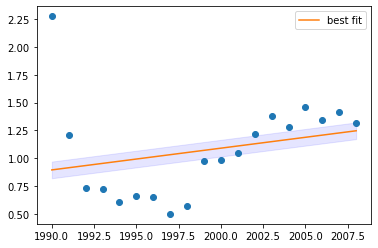

Predictions for next 10 years of CO2 emmisions 


,0,predictions
0,2010,1.285855
1,2011,1.305402
2,2012,1.324950
3,2013,1.344497
4,2014,1.364045
5,2015,1.383592
6,2016,1.403140
7,2017,1.422687
8,2018,1.442235
9,2019,1.461782


In [190]:
yy, yt, result = model(4)
plot(yy, yt, result)
test_data = range(2010,2020)
df_test = pd.DataFrame(test_data)
print("Predictions for next 10 years of CO2 emmisions ")
test_result = df_test
test_result['predictions'] = result.predict(df_test)
test_result

1.0389009512943872


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)


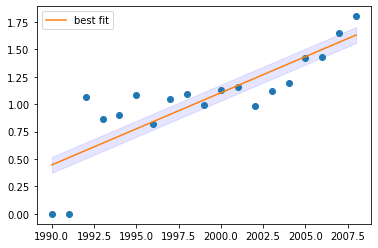

Predictions for next 10 years of CO2 emmisions 


,0,predictions
0,2010,1.762675
1,2011,1.828473
2,2012,1.894270
3,2013,1.960068
4,2014,2.025866
5,2015,2.091663
6,2016,2.157461
7,2017,2.223259
8,2018,2.289056
9,2019,2.354854


In [192]:
yy, yt, result = model(7)
plot(yy, yt, result)
test_data = range(2010,2020)
df_test = pd.DataFrame(test_data)
print("Predictions for next 10 years of CO2 emmisions ")
test_result = df_test
test_result['predictions'] = result.predict(df_test)
test_result